In [1]:
%matplotlib inline
import matplotlib
import sys, os, h5py
import copy
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d

import lal
import pycbc.waveform as wfutils
from pycbc.waveform import get_td_waveform,taper_timeseries
from pycbc.types import FrequencySeries
from pycbc.filter import sigma as optimal_snr
from pycbc.filter.matchedfilter import match

from pycbc.psd import aLIGOEarlyLowSensitivityP1200087



fig_width_pt = 510.
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

fontsize = 16
legendfontsize = 14

params={'text.usetex': True,
        'axes.labelsize': fontsize,
        'font.size': fontsize,
        'legend.fontsize': legendfontsize,
        'xtick.labelsize': fontsize,
        'ytick.labelsize': fontsize,
        'figure.figsize': fig_size,
        'font.weight': 'normal'
       }


import pylab
pylab.rcParams.update(params)
pylab.rcParams['axes.linewidth'] = 1
pylab.rc('axes', linewidth=1)

def touchbox(ax):
    ax.minorticks_on()
    ax.tick_params('both', length=5, width=1, which='major')
    ax.tick_params('both', length=3.5, width=1, which='minor')
    ax.spines['top'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['right'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    return

# plt.style.use('seaborn-darkgrid')


In [2]:
savepath = '../mode_comp/q=2/'
sample_frequency = 4096
phi = 0
q = 'q-2'

In [3]:
mother_freq=0.5
max_scale=512

In [4]:
def waveformgen(numrel_data, mass, iota, mode_array, f_lower):
    wavelabel=os.path.join(savepath, numrel_data.split('/')[-1].replace(".h5",""))

    f = h5py.File(numrel_data, 'r')


    hp, hc = get_td_waveform(approximant='NR_hdf5',
                                 numrel_data=numrel_data,
                                 mass1=f.attrs['mass1']*mass,
                                 mass2=f.attrs['mass2']*mass,
                                 spin1z=f.attrs['spin1z'],
                                 spin2z=f.attrs['spin2z'],
                                 delta_t=1.0/sample_frequency,
                                 inclination=iota,
                                 f_lower = f_lower,
                                 coa_phase=phi,
                                 distance=1000,
                                 mode_array = mode_array
                            )


    f.close()

    # Taper waveform for smooth FFTs
    hp = taper_timeseries(hp, tapermethod="TAPER_START")
    hc = taper_timeseries(hc, tapermethod="TAPER_START")

    amp = wfutils.amplitude_from_polarizations(hp,hc)
    foft = wfutils.frequency_from_polarizations(hp,hc)

    # Shift time origin to merger
    sample_times = amp.sample_times - amp.sample_times[np.argmax(amp)]
    
    # # Trim the timeseries before the CWT
    # hp_red = hp[:int(sample_frequency)]
    
    return hp,hc,amp,foft,sample_times

In [5]:
def plotstrain(data, labels, mass, iota, mode_array, f_lower=10):
    plt.close('all')
    plt.figure(figsize=(fig_width,fig_height))
    for nrd, label in zip(data, labels):
        hp,hc,amp,foft,sample_times = waveformgen(nrd, mass, iota,mode_array, f_lower)
        plt.plot(sample_times, hp, alpha = 0.6, label = label)
    #plt.xlim([-1,0.5])
    plt.xlabel(r'$\textrm{Time (s)}$')
    plt.ylabel(r'$\Re[h(t)]$')
    plt.legend()
    plt.tight_layout()
    mode = str(mode_array[0]).replace(' ', '').replace('[', '').replace(']','')
    figname = os.path.join(savepath, q +'_mode-' + mode +'_strain.png')
    plt.savefig(figname)
    plt.show()

In [6]:
def plotamp(data, labels, mass, iota, mode_array, f_lower=10):
    plt.close('all')
    plt.figure(figsize=(fig_width,fig_height))
    for nrd, label in zip(data, labels):
        hp,hc,amp,foft,sample_times = waveformgen(nrd, mass, iota, mode_array, f_lower)
        plt.plot(sample_times, amp, alpha = 0.6, label = label)
    #plt.xlim([-1,0.5])
    plt.xlabel(r'$\textrm{Time (s)}$')
    plt.ylabel(r'$|h(t)|$')
    plt.legend()
    plt.tight_layout()
    mode = str(mode_array[0]).replace(' ', '').replace('[', '').replace(']','')
    figname = os.path.join(savepath, q +'_mode-' + mode +'_amp.png')
    plt.savefig(figname)
    plt.show()

In [7]:
def get_match(GT, SXS, mass, iota, mode_array, f_lower=10):
    gt_hp,_,_,_,_ = waveformgen(GT, mass, iota, mode_array, f_lower)
    sxs_hp,_,_,_,_ = waveformgen(SXS, mass, iota, mode_array, f_lower)
    hp_len = max(len(gt_hp), len(sxs_hp))
    gt_hp.resize(hp_len)
    sxs_hp.resize(hp_len)
    my_psd = aLIGOEarlyLowSensitivityP1200087(len(gt_hp) / 2 + 1, 1.0 / gt_hp.duration, f_lower)
    return match(gt_hp,sxs_hp,psd=my_psd,low_frequency_cutoff=f_lower)[0]


In [8]:
nrd = ['../GeorgiaTech/GT0446.h5','../SXS_BBH_0169_Res5.h5']
nrdlabel = ["GT0446","SXS-BBH-0169-Res5"]

# 2,1 

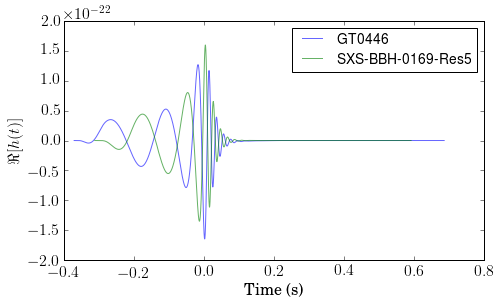

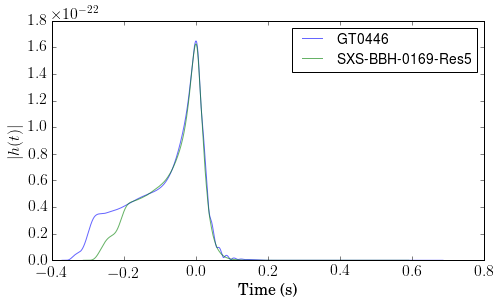

In [9]:
plotstrain(nrd, nrdlabel, 300, np.pi/2, [[2,1]])
plotamp(nrd, nrdlabel, 300, np.pi/2, [[2,1]])

In [10]:
get_match(nrd[0],nrd[1], 300, np.pi/2, [[2,1]])

0.9991628573593869

# 2,2

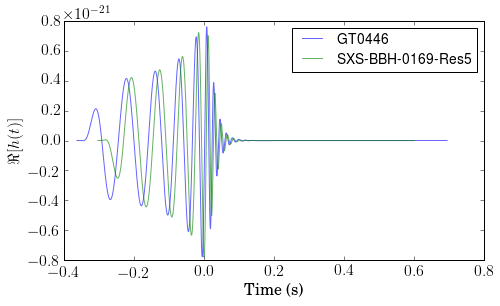

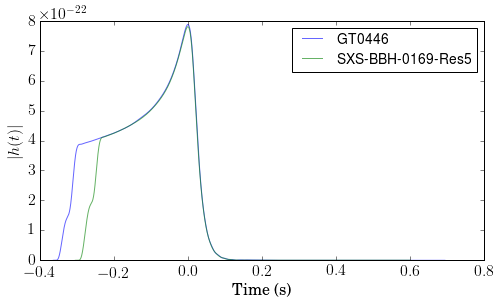

In [11]:
plotstrain(nrd, nrdlabel, 300, np.pi/2, [[2,2]])
plotamp(nrd, nrdlabel, 300, np.pi/2, [[2,2]])

In [12]:
get_match(nrd[0],nrd[1], 300, np.pi/2, [[2,2]])

0.9991197423729863

# 3,2 

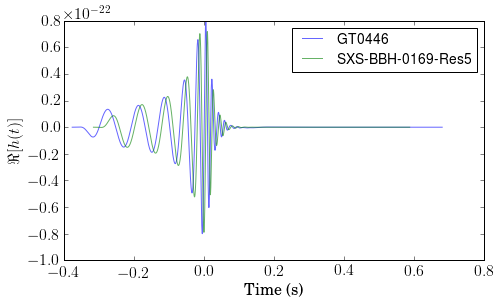

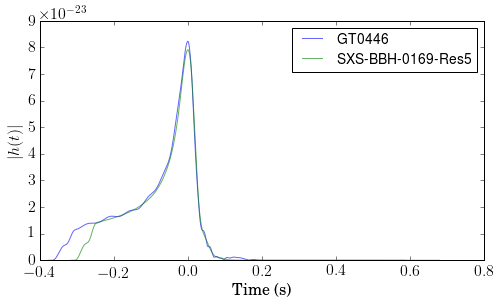

In [13]:
plotstrain(nrd, nrdlabel, 300, np.pi/2, [[3,2]])
plotamp(nrd, nrdlabel, 300, np.pi/2, [[3,2]])

In [14]:
get_match(nrd[0],nrd[1], 300, np.pi/2, [[3,2]])

0.999505503735384

# 3,3

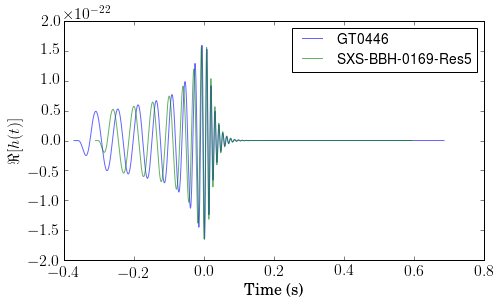

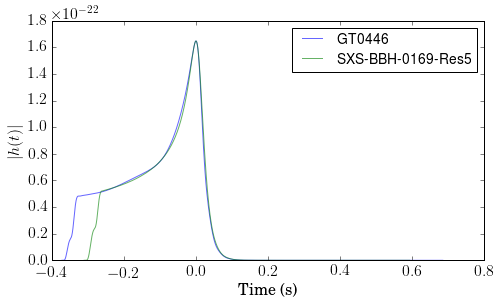

In [15]:
plotstrain(nrd, nrdlabel, 300, np.pi/2, [[3,3]])
plotamp(nrd, nrdlabel, 300, np.pi/2, [[3,3]])

In [16]:
get_match(nrd[0],nrd[1], 300, np.pi/2, [[3,3]])

0.9995210322097958

# 4,3 

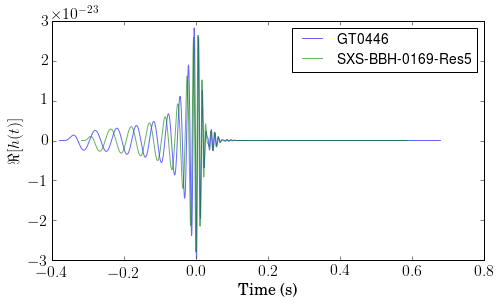

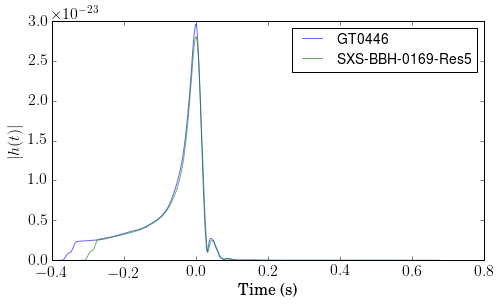

In [17]:
plotstrain(nrd, nrdlabel, 300, np.pi/2, [[4,3]])
plotamp(nrd, nrdlabel, 300, np.pi/2, [[4,3]])

In [18]:
get_match(nrd[0],nrd[1], 300, np.pi/2, [[4,3]])

0.999664523176764

# 4,4 

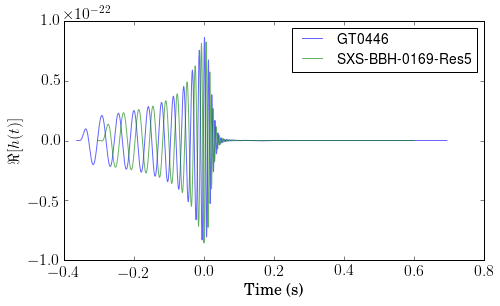

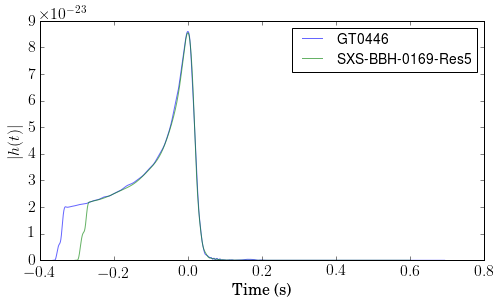

In [19]:
plotstrain(nrd, nrdlabel, 300, np.pi/2, [[4,4]])
plotamp(nrd, nrdlabel, 300, np.pi/2, [[4,4]])

In [20]:
get_match(nrd[0],nrd[1], 300, np.pi/2, [[4,4]])

0.9992855730165405

# 5,4 

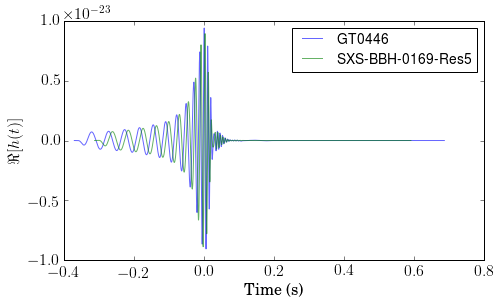

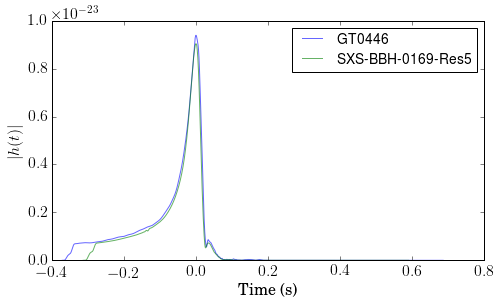

In [21]:
plotstrain(nrd, nrdlabel, 300, np.pi/2, [[5,4]])
plotamp(nrd, nrdlabel, 300, np.pi/2, [[5,4]])

In [22]:
get_match(nrd[0],nrd[1], 300, np.pi/2, [[5,4]])

0.9987199898586502

# 5,5 

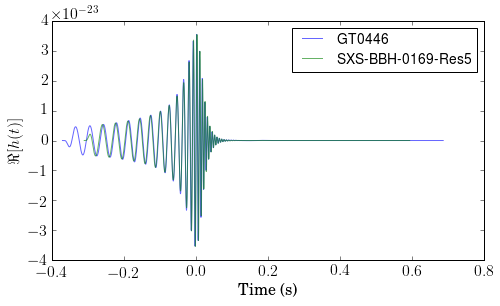

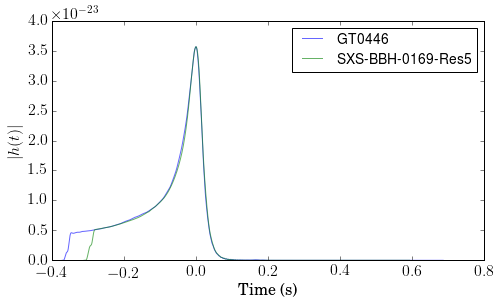

In [23]:
plotstrain(nrd, nrdlabel, 300, np.pi/2, [[5,5]])
plotamp(nrd, nrdlabel, 300, np.pi/2, [[5,5]])

In [24]:
get_match(nrd[0],nrd[1], 300, np.pi/2, [[5,5]])

0.9991354301422317